In [1]:
import warnings
warnings.filterwarnings('ignore')

#
# **Importando os dados**

In [2]:
import pandas as pd

uri= ("https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv")
# dados= pd.read_csv(uri, index_col= 0) <- mesma funcionalidade e resultado do codigo abaixo
dados= pd.read_csv(uri).drop(columns= ['Unnamed: 0'], axis= 1)

In [3]:
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


#
# **Modelagem**

## *Cross Validate*

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [5]:
# CLASSIFICANDO OS DADOS (X & Y)
x= dados[['preco', 'idade_do_modelo', 'km_por_ano']]
y= dados['vendido']

# REALIZANDO O HOLDOUT (a técnica de separar uma parte dos dados para treino e outra para testes é chamada de Holdout)
SEED= 158020
np.random.seed(SEED)
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25, stratify= y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(x_train), len(x_test)))

Treinaremos com 7500 elementos e testaremos com 2500 elementos


In [6]:
# CRIANDO UMA BASE/BASELINE (DUMMY CLASSIFIER)
dmy_stratified= DummyClassifier(strategy= 'stratified')
dmy_stratified.fit(x_train, y_train)
dmy_stratified_acc= dmy_stratified.score(x_test, y_test) * 100

print("A acurácia do dummy stratified foi %.2f%%" % (dmy_stratified_acc))

A acurácia do dummy stratified foi 50.96%


In [7]:
# CRIANDO O MODELO (DESCISION TREE CLASSIFIER)
SEED= 158020
np.random.seed(SEED)
model= DecisionTreeClassifier(max_depth= 2)
model.fit(x_train, y_train)
model_acc= model.score(x_test, y_test) * 100

print("A acurácia foi %.2f%%" % (model_acc))

A acurácia foi 71.92%


#### Suponhamos que experts humanos são capazes de acertar 73%. Para nos igualarmos a eles, precisaremos mudar o algorítimo.

#### Entretanto, reparem que o código tem um SEED de 158020, que é um número qualquer escolhido aleatoriamente, para que pudéssemos rodar várias vezes, obtendo o mesmo resultado. Então, o que mudaria se alterássemos esse valor?

#### Vamos aplicar alguns testes, copiando e colando o mesmo código:

In [8]:
# REALIZANDO OS TESTES COM NUMEROS DIFERENTES PARA O SEED
SEED= 5
np.random.seed(SEED)
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25, stratify= y)
model= DecisionTreeClassifier(max_depth= 2)
model.fit(x_train, y_train)
model_acc= model.score(x_test, y_test) * 100

print("A acurácia foi %.2f%%" % (model_acc))

A acurácia foi 76.84%


#### A acurácia sobe para 76.84%, quase 77%! 
#### Então, aquela decisão de julgar isso como bom ou ruim em comparação ao que obtínhamos com Dummy Classifier está melhor, entretanto, ainda estamos vulneráveis a tomar uma decisão baseada em uma aleatoriedade. Não faz sentido validar, julgar se é bom ou ruim, de acordo com um número aleatório.
#### Queremos minimizar o efeito dessa aleatoriedade, dessa escolha aleatória do treino, do teste e da DecisionTreeClassifier, na nossa decisão.

#### No entanto, se rodamos o treino e o teste uma única vez, corremos o risco de os ter separado mal. Precisamos de outra forma de treinar e testar mais de uma vez para que não tenhamos uma estimativa única, uma maneira que permita rodar o treino e o teste diversas vezes e, a partir disso, obter uma estimativa.

#### Em vez de um ponto, queremos um intervalo. Precisamos encontrar um método, um algorítimo para isto.

#### Utilizaremos a validação cruzada K-fold (K-fold Cross Validation), que é quando o conjunto de dados é dividido em um número K de dobras e é usado para avaliar a capacidade do modelo quando dados novos são fornecidos. K se refere ao número de grupos/pedaços em que a amostra de dados é dividida. Por exemplo, se você vir que o valor k é 5, podemos chamar isso de validação cruzada de 5 dobras ou 5-fold-cross-validation. <br>
#### *https://cursos.alura.com.br/course/machine-learning-validando-modelos/task/48273*

In [9]:
from sklearn.model_selection import cross_validate

In [10]:
# CRIANDO O MODELO
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x, y, cv= 3, return_train_score= False)#cv representa a quantidade de vezes em que os dados serao quebrados
results['test_score']
#o codigo devolvera 3 notas como apresenta o output, pois separamos em treino e teste 3 vezes atraves do cv= 3

array([0.75704859, 0.7629763 , 0.75337534])

In [11]:
# TESTANDO O ACCURACY
media= results['test_score'].mean()
desvio_padrao= results['test_score'].std()

print("Accuracy com cross validation 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))
# pq 2 * desvio_padrao? representa o nivel de confianca que queremos trabalhar, que seria de aprox. 95%, como mostra a imagem abaixo:
# μ = media, σ = desvio padrao

Accuracy com cross validation 3 = [74.99, 76.57]


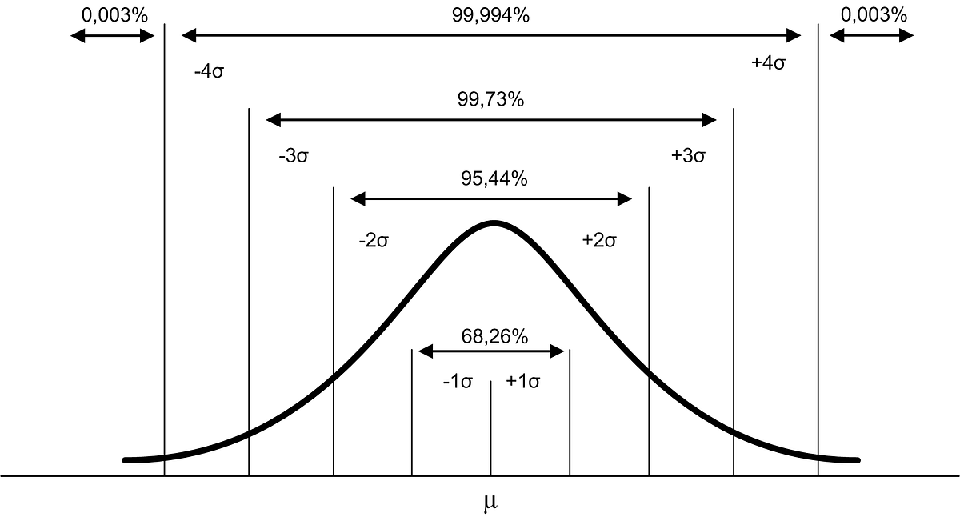

In [12]:
# SEED= 301              Percebam que mudamos o valor de SEED, mas Accuracy se mantém. Podemos alterar novamente SEED, para 301, por 
# np.random.seed(SEED)   exemplo, e o intervalo permanecerá o mesmo. Ou seja, nosso algorítimo não está mais tão suscetível a essa 
#                        aleatoriedade! Contudo, estamos suscetíveis ao número de cv.

# TESTANDO O ACCURACY, POREM COM OUTRO CV (10)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x, y, cv= 10, return_train_score= False)

media= results['test_score'].mean()
desvio_padrao= results['test_score'].std()

print("Accuracy com cross validation 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy com cross validation 10 = [74.24, 77.32]


In [13]:
# TESTANDO O ACCURACY, POREM COM OUTRO CV (5)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x, y, cv= 5, return_train_score= False)

media= results['test_score'].mean()
desvio_padrao= results['test_score'].std()

print("Accuracy com cross validation 5 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy com cross validation 5 = [75.21, 76.35]


## *Aleatoriedade no Cross Validate*

#### Notem que o cross_validate() não recebe o parâmetro de aleatoriedade, e esse é o padrão. <br>Da maneira utilizada por nós, ele é determinístico, e nós sabemos em quantos pedaços ele quebrará os dados, porque somos nós quem decidimos essa quantidade. Portanto, a realidade é que a aleatoriedade (random_state, seed, ...) só é aplicada no DecisionTreeClassifier(). E, por padrão, ele só a usará em um caso específico e raro. <br>Por estas razões, mesmo que mudemos constantemente o valor de SEED, obteremos basicamente sempre os mesmos números.

#### A ideia era rodar aleatoriamente, de fato. Por mais que recebamos todos os dados em uma sequência, não queremos quebrar eles em 5 pedaços e, a partir disso, fazer o cross_validate. O ideal seria embaralhar estes dados e, então executar a validação cruzada. O algorítimo pode fazer isso de maneira mais inteligente, sem embaralhar e copiar todo o espaço de memória e todos os objetos que estiverem dentro, e assim por diante. <br>Mas o importante é a ideia de embaralhar esses dados de alguma maneira, e o cross_validate não faz isso de verdade.

#### O que desejamos modificar é a aleatoriedade, nós desejamos que ele embaralhe nossos dados, entretanto, não existe um parâmetro para isto. Todavia, o cv aceita como parâmetro, tanto números, quanto geradores de validação cruzada. E existem diversos geradores de validação cruzada. O que estamos usando é o KFold, que "corta" nossos dados em K pedaços.

In [14]:
from sklearn.model_selection import KFold

In [15]:
# CRIANDO O GENERETOR (KFold SEM shuffle (POR PADRAO))
cv_generator= KFold(n_splits= 10)

# CRIANDO O MODELO (cv= kfold)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x, y, cv= cv_generator, return_train_score= False)

# media= results['test_score'].mean()
# desvio_padrao= results['test_score'].std()

# CRIANDO FUNCAO print_results (PARA NAO PRECISAR CODAR media, desvio_padrao E print() TODA VEZ)
def print_results (results):
    media= results['test_score'].mean()
    desvio_padrao= results['test_score'].std()
    print("Accuracy mean = %.2f" % (media * 100))
    print("Accuracy interval = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))
    
print_results(results)

Accuracy mean = 75.78
Accuracy interval = [74.37, 77.19]


In [16]:
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# CRIANDO O GENERATOR (KFold COM shuffle)
cv_generator= KFold(n_splits= 10, shuffle= True)

model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x, y, cv= cv_generator, return_train_score= False)

print_results(results)

Accuracy mean = 75.76
Accuracy interval = [73.26, 78.26]


## *Simular situação horrível de azar*

#### Sempre podemos ter muito azar em uma condição muito específica. Antes de trabalharmos com validação cruzada, estudamos uma questão de sorte e azar em que a validação era simples: treino-teste. Tínhamos o azar de que nossos dados, no momento de realmente utilizá-los, eram separados como, por exemplo, vendido ou não vendido. <br> Como resultado, no treino estavam quase todos que não foram vendidos e no teste quase todos que foram vendidos. Ou seja, ocorria um desbalanceamento das classes, seja no conjunto inteiro de dados ou na hora de treinar e testar, e seja pela aleatoriedade ou pela natureza dos dados.

#### Quando separávamos o treino e o teste com o train_test_split tínhamos o Stratify como parâmetro, que definia a proporção. Por exemplo, se temos 70% dos dados na classe 0 (não vendido) e 30% na classe 1 (vendido), ele distribui 70% e 30% tanto para treino, quanto para teste. <br> No entanto, esse parâmetro não existe no cross_validate do KFold, que possui apenas os parâmetros n_splits, shuffle e random_state. <br> Então, vamos simular uma situação de azar para podermos aprimorar nosso processo.

In [17]:
# ORDENANDO OS DADOS PARA QUE A COLUNA vendido FIQUE CRESCENTE, SIMULANDO UMA SITUACAO DE AZAR
dados_azar= dados.sort_values('vendido', ascending= True)
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [18]:
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# SEPARANDO SO DADOS AZARADOS
x_azar= dados_azar[['preco', 'idade_do_modelo', 'km_por_ano']]
y_azar= dados_azar['vendido']

# FAZENDO O TESTE COM O CROSS VALIDATE E OS DADOS AZARADOS(SEM O shuffle)
cv_generator= KFold(n_splits= 10)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, return_train_score= False)

print_results(results)

Accuracy mean = 57.84
Accuracy interval = [34.29, 81.39]


In [19]:
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# FAZENDO O TESTE COM O CROSS VALIDATE E OS DADOS AZARADOS(COM O shuffle)
cv_generator= KFold(n_splits= 10, shuffle= True)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, return_train_score= False)

print_results(results)

Accuracy mean = 75.78
Accuracy interval = [72.30, 79.26]


#### O shuffle nos é suficientemente bom nesta situação em que temos balanço para recuperar, mas e se quiséssemos fazer a estratificação? <br> Além do KFold, temos outros geradores de grupo de separação, dentre eles o StratifiedKFold, que recebe um número de n_splits, shuffle e depois separa, mantendo a proporção entre as classes.

In [20]:
from sklearn.model_selection import StratifiedKFold

In [21]:
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# FAZENDO O TESTE COM O CROSS VALIDATE, OS DADOS AZARADOS E O STRATIFIED KFOLD (COM O shuffle)
cv_generator= StratifiedKFold(n_splits= 10, shuffle= True)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, return_train_score= False)

print_results(results)

Accuracy mean = 75.78
Accuracy interval = [73.55, 78.01]


## *Dados agrupáveis*

#### É preciso tomar cuidado quando formos separar o treino e o teste. Temos que pensar que, ao treinarmos nosso algorítimo, nós treinamos ele com os dados; quando nós testamos, temos que ser capazes de testar como se fosse no mundo real. Entretanto, por exemplo, quando o Carlos entra no hospital, ele é um paciente novo e ainda não há dados sobre ele.<br>No mundo real em um hospital, ele é um paciente novo, nunca visto, e aquilo que fora treinado com outros pacientes precisa funcionar com ele também. Na hora de separarmos treino e teste, teríamos de agrupar pelos pacientes. Nós não poderíamos colocar dados da Ana no treino e no teste, porque cada paciente é uma pessoa nova, no mundo real do hospital. Claro, o paciente pode voltar, mas queremos ser capazes de trabalhar com pacientes novos. E se nos treinos e testes temos repetições de pacientes, é possível que o algorítimo não generalize bem, para novos pacientes.

#### Até o momento, ainda não existe um modelo de carro chamado "Super Vitor". Pode ser que esse modelo seja inventado daqui a 10 anos, por exemplo. Mas quando ele passar a existir, é preciso que sejamos capazes de prever para ele também. Para isto, no momento em que formos treinar, precisaremos agrupar por modelo e separar a validação cruzada por modelos, para depois testar modelos novos. <br>Então, vamos pegar essa característica de agrupamento e tentar trabalhar nos nossos dados. Ou seja, no caso dos carros, trata-se do modelo do veículo.

#### Contudo, nota-se que nossos dados (preco, vendido, idade_do_modelo e km_por_ano) não têm a categoria modelo_do_carro. Então, vamos explorar como gerar uma nova coluna de dados para explorarmos esses dados aleatórios.

In [22]:
# É possível imaginar que o modelo de um carro esteja muito ligado a idade dele. Por exemplo, se um carro tem 20 anos, é mais provável que seja um 
# modelo similar ao modelo de 18 anos atrás, do que ao modelo de 3 anos atrás. Isto posto, vamos usar o dado idade_do_modelo para gerar o modelo de
# um carro, de alguma maneira. A maneira mais simples seria nós usarmos dados.idade_do_modelo, isto é, o modelo do carro seria a idade_do_modelo desse
# carro. Entretanto, essa é uma premissa falsa, uma vez que nem todos os carros que tem 20 anos necessariamente são do mesmo modelo. Em vez disso, 
# temos que injetar aleatoriedade. Por exemplo, se o carro foi criado há 18 anos, talvez esse carro seja de um modelo A, B ou C. Um modelo do ano 18,
# 17 ou 19 — com margem um pouco para trás e um pouco para frente.

# CRIANDO UMA COLUNA COM MODELOS ALEATORIOS PARA SIMULACAO DE AGRUPAMENTO AO USAR NOSSO ESTIMADOR(modelo_aleatorio)
np.random.seed(SEED) # usando a seed para obter resultados igual aos da aula
dados['modelo_aleatorio']= dados['idade_do_modelo'] + np.random.randint(-2, 3, size= 10000)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,18,35085.22134,16
1,40557.96,1,20,12622.05362,22
2,89627.50,0,12,11440.79806,12
3,95276.14,0,3,43167.32682,4
4,117384.68,1,4,12770.11290,3


In [23]:
# VISUALIZANDO VALORES UNICOS DOS MODELOS (modelo_aleatorio)
dados['modelo_aleatorio'].unique() # note que a um numero negativo (-1)

array([16, 22, 12,  4,  3, 11, 18, 17, 13,  0, 15, 10,  9, 14,  1,  5, 19,
       21,  8,  7, 20,  6,  2, -1], dtype=int64)

In [24]:
# CORRIGINDO O VALOR NEGATIVO (modelo_aleatorio= -1 ???)
# OPCAO 1 (SOLUCAO QUE EU ENCONTREI):
# dados['modelo_aleatorio'].where(dados['modelo_aleatorio'] != -1, 0, inplace= True) <-dessa forma, eu substituo apenas os -1's por 0's, sem alterar os
                                                                                     # outros valores da coluna, porem como o prof fez utilizando a 
                                                                                     # opcao 2, tambem farei para obter os mesmos resultados da aula.
# OPCAO 2 (ESTRATEGIA USADA NA AULA):
# prof somou +1 ao final pois acha entranho o modelo ser 0, 1, 2, 3, ..., e prefere que o modelo inicial seja 1.
dados['modelo_aleatorio']= abs(dados['modelo_aleatorio'].min()) + dados['modelo_aleatorio'] + 1
display(dados['modelo_aleatorio'].min())
dados.head()

1

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


#### Agora que geramos os dados que gostaríamos, mudaremos o nome do campo modelo_aleatorio para simplesmente modelo

In [25]:
dados.rename(columns= {'modelo_aleatorio':'modelo'}, inplace= True)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


#### Agora que temos os dados criados, como modelo do carro, precisamos testar nosso estimador. Para isto, é muito importante pensar qual tipo de treino e teste será utilizado, pois se escolhermos um tipo inapropriado, obteremos uma estimativa irreal de como esse estimador funcionará no mundo real.<br> Nos queremos ser capazes de separar treino e teste na validacao cruzada de acordo com os grupos, e atraves do KFold convencional e do Stratified KFold nos nao temos essa capacidade. <br> Se formos ao scikit-learn, encontraremos a validação cruzada que separa por grupo: Group KFold.

In [26]:
from sklearn.model_selection import GroupKFold

In [27]:
# FAZENDO OS TESTES DE VALIDACAO CRUZADA, POREM DESSA VEZ USANDO O GROUP KFOLD
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# shuffle nao eh mais necessario ja que estamos utilizando um gerador que faz a separacao por grupos, nao ha o que randomizar por conta do agrupamento.
cv_generator= GroupKFold(n_splits= 10) 
model= DecisionTreeClassifier(max_depth= 2)
# o prof ainda esta usando os dados azar, mas nao sei pq... deixei igual para obter os mesmos resultados da aula
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, return_train_score= False, groups= dados['modelo'])

print_results(results)

Accuracy mean = 75.78
Accuracy interval = [73.67, 77.90]


## *Cross Validation com StandardScaler*

##### <br>*https://cursos.alura.com.br/course/machine-learning-validando-modelos/task/48280*

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [29]:
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# CRIANDO O ESCALADOR E OS DADOS REESCALADOS (StandardScaler)
scaler= StandardScaler()
scaler.fit(x_train)
scaled_x_train= scaler.transform(x_train)
scaled_x_test= scaler.transform(x_test)

# CRIANDO O MODELO UTILIZANDO O SVC E TESTANDO A ACURACIA
model= SVC()
model.fit(scaled_x_train, y_train)
model_acc= model.score(scaled_x_test, y_test) * 100

print("A acurácia foi %.2f%%" % (model_acc))

A acurácia foi 77.48%


In [63]:
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# CRIANDO O MODELO UTILIZANDO O SVC E O CROSS VALIDATE COM AGRUPAMENTO (GROUP KFOLD)
scaler= StandardScaler()
scaler.fit(x_azar)
scaled_x_azar= scaler.transform(x_azar)
# nao entendi muito bem o porque do prof. ter utilizados os dados azarados para realizar esse teste, porem acredito que tenha sido pelo fato desses 
# dados azarados nao terem sido separados em treino e teste, por isso fixei o link da aula no markdown. alem do link tem uma explicacao abaixo.
cv_generator= GroupKFold(n_splits= 10)
model= SVC()
results= cross_validate(model, scaled_x_azar, y_azar, cv= cv_generator, return_train_score= False, groups= dados['modelo'])

print_results(results)

Accuracy mean = 76.70
Accuracy interval = [74.30, 79.10]


#### Entretanto, no pré processamento de dados, quando escalamos as features, fit() é aplicado somente nos dados de treino, e aqui o fit() acontece em treino e teste por conta dos dados azarados (x_azar, scaled_x_azar). Até porque faremos dez separações baseadas nos grupos, para treinar e testar. Ou seja, não faremos o fit() somente uma vez. Devemos fazer esse fit() diversas vezes. Na verdade, deveríamos intercalar, fazendo uma vez esse fit, uma vez a validação, uma vez o fit, outra vez a validação, com outro conjunto de dados.<br>Toda vez que rodamos o GroupKFold, temos que fazer o fit() com uma parte de treino e rodar a validação com o teste. Se tivermos outro treino, rodaremos fit() para esse outro treino, e o teste com o resto. Assim, teremos um processo de duas fases:<ul><li>Primeiro, o pré processamento que escala;</li><li>depois, a validação.</li></ul>Esse processo deve ser rodado várias vezes, de acordo com os nossos grupos e com nossos com nossos splits. Então, precisamos pensar em outra forma, além de fazer o fit() somente uma vez e, depois, rodar o GroupKFold. Provavelmente, a estimativa obtida por esse processo está muito otimista.<br>Sendo assim, no Sklearn, criaremos um processo, uma sequência de passos, conhecido como Pipeline.

In [64]:
from sklearn.pipeline import Pipeline

In [65]:
# CRIANDO O SCALER, O ESTIMADOR E O PIPELINE PARA VIZUALIZACAO E ENTENDIMENTO (1st- Pre-processing(scaler), 2nd- Validation(model))
scaler= StandardScaler()
model= SVC()
pipeline= Pipeline([('scaler',scaler), ('estimator',model)]) # Pipeline recebe uma lista de tuplas encadeadas em ordem, sendo primeiro o escalador e 
                                                             # depois o estiamdor. Desse modo, se imprimirmos ou analisarmos por dentro, encontraremos:
                                                             # primeiro uma transformação, que é o Standrscaler(), e depois um estimador que é o SVC().
pipeline
# O legal do Pipeline é que ele funciona como se fosse um estimador, então tem o fit() e o predict(), que funciona da mesma forma. Então, podemos passar
# ele para o processo de cross_validate.

Pipeline(steps=[('scaler', StandardScaler()), ('estimator', SVC())])

In [72]:
SEED= 301             # coloquei a seed apenas pq o professor estava usando na aula, ao remover 
np.random.seed(SEED)  # a seed os resultados serao diferentes a cada run do codigo.

# UTILIZANDO O PIPELINE JUNTAMENTE AO CROSS VALIDATE
scaler= StandardScaler()
model= SVC()
pipeline= Pipeline([('scaler', scaler), ('estimator', model)])

cv_generator= GroupKFold(n_splits= 10)
results= cross_validate(pipeline, x_azar, y_azar, cv= cv_generator, return_train_score= False, groups= dados['modelo'])
# Ao cross validar o pipeline inteiro, nao eh necessario reescalar os dados justamente porque o pipeline ja vai fazer isso. Para cada um dos processos
# de fold, serão rodados tanto o scaler, quanto o estimador. Depois, outro conjunto de dados será separado em dois, tanto o scaler, quanto o estimador,
# e assim vai. Portanto, a execução do código vai demorar um pouco mais. O importante é que teremos uma estimativa mais realista do modelo SVC(), com
# StandardScaler, no mundo real, considerando agrupamentos.

print_results(results)

Accuracy mean = 76.68
Accuracy interval = [74.28, 79.08]


#### Reparem que o valor anterior e este não são tão distantes, mas é preciso entender que a forma feita anteriormente estava errada, porque rodávamos o scaler somente uma vez, para depois rodar os KFolds. Não é questão de estar melhor ou pior, pois estamos falando de um processo, que deve ser rodado para cada uma das fases de treino. Portanto, se tivermos 10 fases de treino, teremos que rodar o scaler para cada uma do conjunto de treino. E é isso que o Pipeline faz para nós, de forma muito mais prática. Basta inserir todas as fases nele e rodar. Claro, pode demorar um pouco mais, mas é a opção que faz mais sentido.

#### https://cursos.alura.com.br/course/machine-learning-validando-modelos/task/
#### https://machinelearningmastery.com/train-final-machine-learning-model/

In [82]:
model= SVC()
model.fit(x, y)
pipeline= Pipeline([('scaler', scaler), ('estimator', model)])
results= cross_validate(pipeline, x, y, cv= cv_generator, groups= dados['modelo'])
print_results(results)

Accuracy mean = 76.55
Accuracy interval = [73.22, 79.88]
